In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("China Financial Statement Analysis and Anomaly Detection Dataset (CFSAAD 2021 2025).csv")

In [4]:
df.head()

,company_id,company_name,year,industry,region,revenue,net_profit,total_assets,total_liabilities,equity,...,audit_opinion,fraud_risk_score,g_index,esg_score,stock_volatility,market_cap,ownership_type,risk_category,audit_firm,financial_health_index
0,SH969694,Haier Precision Ltd.,2022,Manufacturing,Sichuan,10842.32,1941.90,16828.60,6075.45,10753.15,...,Qualified,0.37,1,61,0.18,32356.57,Private,Low,Big4,0.15
1,SH319685,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,10645.28,522.59,15085.21,10776.40,4308.81,...,Standard,0.18,2,61,0.33,28095.09,Private,Low,Local Tier 1,0.08
2,SZ694732,Sinopec Green Energy,2022,Energy,Sichuan,8993.79,2226.45,13173.37,4370.65,8802.72,...,Standard,0.74,8,63,0.36,21973.57,Private,High,Local Tier 2,0.21
3,SZ358608,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,5305.38,1238.70,8370.68,3011.75,5358.93,...,Standard,0.56,10,42,0.57,11651.27,SOE,Medium,Local Tier 1,0.19
4,SZ245052,CRRC Urban Transit,2021,Transportation,Jiangsu,9084.19,2759.81,16503.92,9025.96,7477.96,...,Standard,0.42,2,57,0.25,28162.58,Private,Medium,Local Tier 1,0.27


In [5]:
df.shape

(37325, 27)

In [6]:
### check duplicate
df.duplicated().sum()

0

In [7]:
### check whether missing value
df.isnull().sum()

company_id                0
company_name              0
year                      0
industry                  0
region                    0
revenue                   0
net_profit                0
total_assets              0
total_liabilities         0
equity                    0
operating_cash_flow       0
roe                       0
roa                       0
debt_to_equity_ratio      0
profit_margin             0
anomaly_label             0
credit_rating             0
audit_opinion             0
fraud_risk_score          0
g_index                   0
esg_score                 0
stock_volatility          0
market_cap                0
ownership_type            0
risk_category             0
audit_firm                0
financial_health_index    0
dtype: int64

In [8]:
### check outliers 
numeric = ["revenue","net_profit","total_assets","total_liabilities","equity",
    "operating_cash_flow","roe","roa","debt_to_equity_ratio","profit_margin",
    "fraud_risk_score","g_index","esg_score","stock_volatility","market_cap",
    "financial_health_index"]

df_check = df[numeric]

z_scores = np.abs(stats.zscore(df_check))
outliers_z = (z_scores > 3).sum(axis=0)
print(outliers_z)

revenue                    68
net_profit                302
total_assets              152
total_liabilities         284
equity                    312
operating_cash_flow       321
roe                       481
roa                       210
debt_to_equity_ratio      261
profit_margin             152
fraud_risk_score            0
g_index                     0
esg_score                   0
stock_volatility          126
market_cap                239
financial_health_index    367
dtype: int64


In [9]:
### Pipline to handle the outliers. I use the mean that exclude the outliers to replace the outliers.
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.clean_means_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        if self.cols is None:
            self.cols = X.select_dtypes(include=[np.number]).columns
        
        for col in self.cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            clean_vals = X.loc[(X[col] >= lower) & (X[col] <= upper), col]
            self.clean_means_[col] = clean_vals.mean()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            X.loc[(X[col] < lower) | (X[col] > upper), col] = self.clean_means_[col]
        return X

pipeline = Pipeline([
    ("outlier_handler", OutlierHandler(cols=numeric))
])

df_clean = pipeline.fit_transform(df)

In [10]:
### But there still are some outliers. There are 37325 rows. Only 20 outilers. 
### I just ignore these twenty outilers.
### And I will not use debt_to_equity_ratio to do the K-means cluster. I will choose some variables that 
### are representative and contains enough informations. 
z_scores_clean = np.abs(stats.zscore(df_clean[numeric]))
outliers_z_clean = (z_scores_clean > 3).sum(axis=0)
print(outliers_z_clean)

revenue                    0
net_profit                 0
total_assets               0
total_liabilities          0
equity                     0
operating_cash_flow        0
roe                        0
roa                        0
debt_to_equity_ratio      20
profit_margin              0
fraud_risk_score           0
g_index                    0
esg_score                  0
stock_volatility           0
market_cap                 0
financial_health_index     0
dtype: int64


In [11]:
df_clean.head()

,company_id,company_name,year,industry,region,revenue,net_profit,total_assets,total_liabilities,equity,...,audit_opinion,fraud_risk_score,g_index,esg_score,stock_volatility,market_cap,ownership_type,risk_category,audit_firm,financial_health_index
0,SH969694,Haier Precision Ltd.,2022,Manufacturing,Sichuan,10842.32,1941.90,16828.60,6075.45,10753.15,...,Qualified,0.37,1.0,61.0,0.18,32356.57,Private,Low,Big4,0.15
1,SH319685,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,10645.28,522.59,15085.21,10776.40,4308.81,...,Standard,0.18,2.0,61.0,0.33,28095.09,Private,Low,Local Tier 1,0.08
2,SZ694732,Sinopec Green Energy,2022,Energy,Sichuan,8993.79,2226.45,13173.37,4370.65,8802.72,...,Standard,0.74,8.0,63.0,0.36,21973.57,Private,High,Local Tier 2,0.21
3,SZ358608,Guangzhou Pharma Group,2022,Pharmaceuticals,Hebei,5305.38,1238.70,8370.68,3011.75,5358.93,...,Standard,0.56,10.0,42.0,0.57,11651.27,SOE,Medium,Local Tier 1,0.19
4,SZ245052,CRRC Urban Transit,2021,Transportation,Jiangsu,9084.19,2759.81,16503.92,9025.96,7477.96,...,Standard,0.42,2.0,57.0,0.25,28162.58,Private,Medium,Local Tier 1,0.27


In [12]:
#df_clean[["net_profit", "roa", "financial_health_index", "market_cap"]]

print(df_clean["net_profit"].mean(), df_clean["roa"].mean(), df_clean["financial_health_index"].mean(), df_clean["market_cap"].mean(), df_clean["esg_score"].mean(), df_clean["g_index"].mean())

1378.843988881925 10.385209160637546 0.16979503480024113 21869.270005433307 62.84214333556597 5.494735432016075


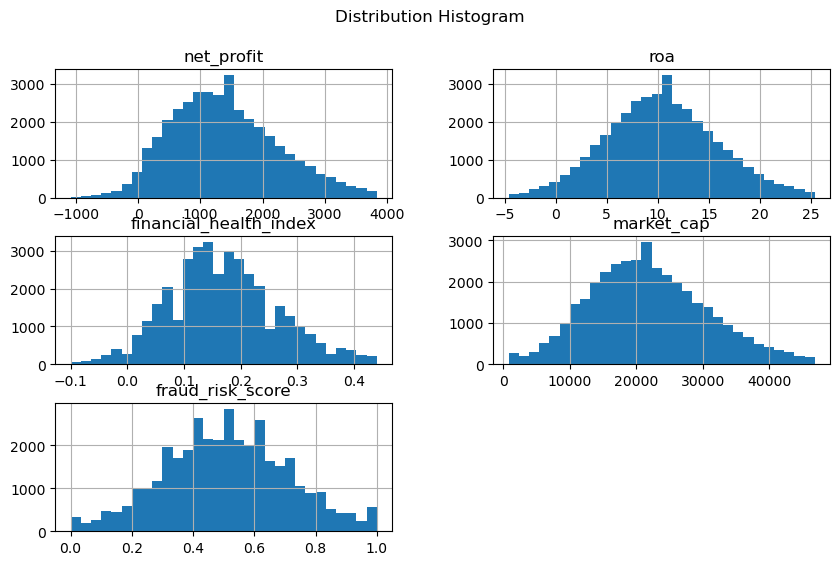

In [ ]:
df_check_distribution = df_clean[["net_profit", "roa", "financial_health_index", "market_cap", "fraud_risk_score"]]

df_check_distribution.hist(bins=30, figsize=(10,6))
plt.suptitle("Distribution Histogram")
plt.show()
# normal distribution? shit dataset

In [14]:
### After pre-processing the data, we turn to the K-Means cluster.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# first, do the standardliztaion to the factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["esg_score", "g_index"]])

# giving k a range, find the best k in that range
inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # SSE
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

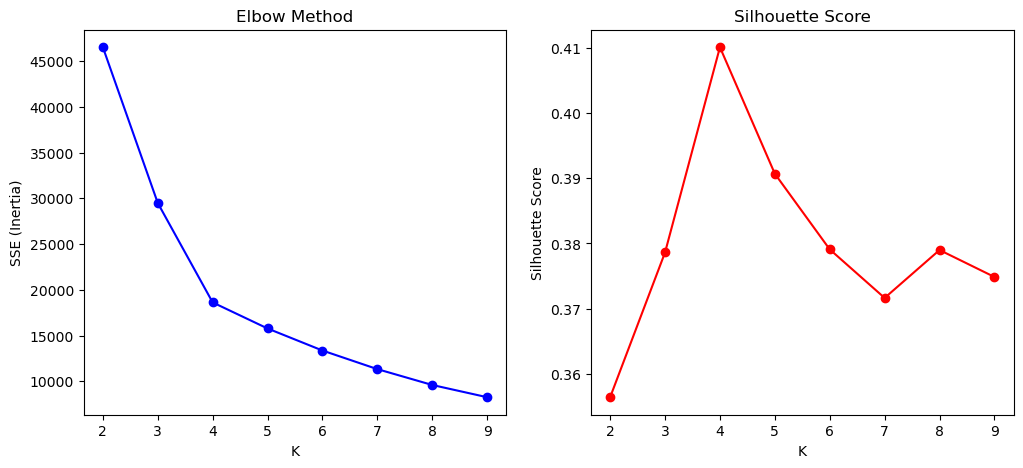

In [ ]:
plt.figure(figsize=(12,5))

# Elbow Method
# As the number of clusters k increases, SSE will monotonically decrease.
# However, when k exceeds a certain point, the decline in SSE will significantly slow down - at this point, 
# continuing to increase the number of clusters will not bring much benefit.
plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

# Silhouette Coefficient
# The closer it is to 1, the better the clustering effect at this point is (tight and separated from other clusters).
plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()
# The best K is 4, according to these two graphs.

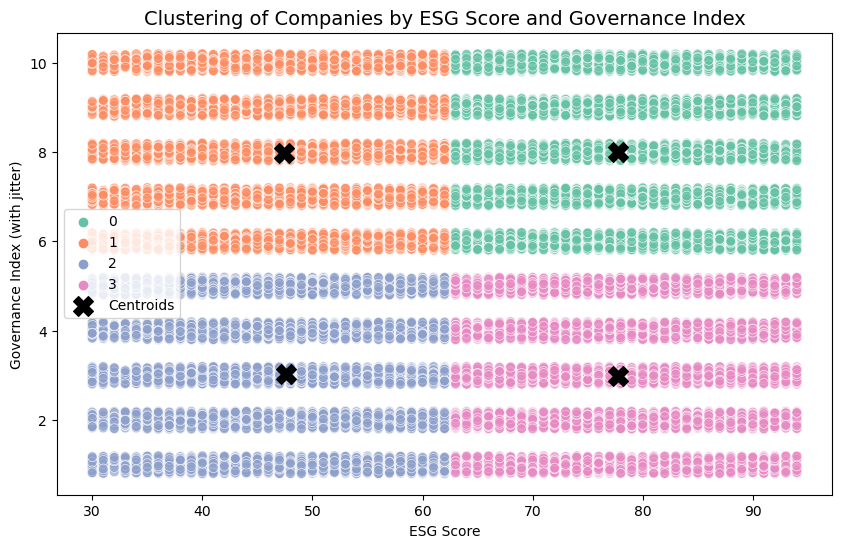

In [ ]:
# Visualization
df_clean["g_index_jitter"] = df_clean["g_index"] + np.random.uniform(-0.2, 0.2, size=len(df_clean))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x="esg_score", 
    y="g_index_jitter", 
    hue="cluster", 
    palette="Set2", 
    alpha=0.7,
    s=50
)

centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(
    centers_original[:,0], 
    centers_original[:,1], 
    c="black", marker="X", s=200, label="Centroids"
)

plt.xlabel("ESG Score")
plt.ylabel("Governance Index")
plt.title("Clustering of Companies by ESG Score and Governance Index", fontsize=14)
plt.legend()
plt.show()

### Cluster 1: High ESG, High Governance 
These companies have demonstrated outstanding performance in terms of sustainable development and governance structure. 
Typically, they represent the leading enterprises in the industry and may be more favored in terms of investor relations and compliance. 

### Cluster 2: Low ESG, Low Governance 
The ESG performance and governance structure are both relatively weak. 
The potential risks are high, and there may be more regulatory and reputational challenges to face. 

### Cluster 3: High ESG, Low Governance 
It performed well in terms of environmental protection and social responsibility, but the governance mechanism was relatively lacking. 
There may be a situation where "external sustainability" is disconnected from "internal management". 

### Cluster 4: Low ESG, High Governance 
The company's governance framework is relatively strong, but it lags behind in the ESG score. 
Such enterprises have the potential to further enhance their overall performance by strengthening their environmental and social responsibility efforts.

### Cluster 1 company is the optimal company. And the cluster 2 company is the worst one. Cluster 3 and 4 company have some disadvantages. Should formulate targeted and differentiated strategies.

In [18]:
# adding some financial factors. but no better. So we just ignore the financial factors.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["esg_score", "g_index", "debt_to_equity_ratio"]])

inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

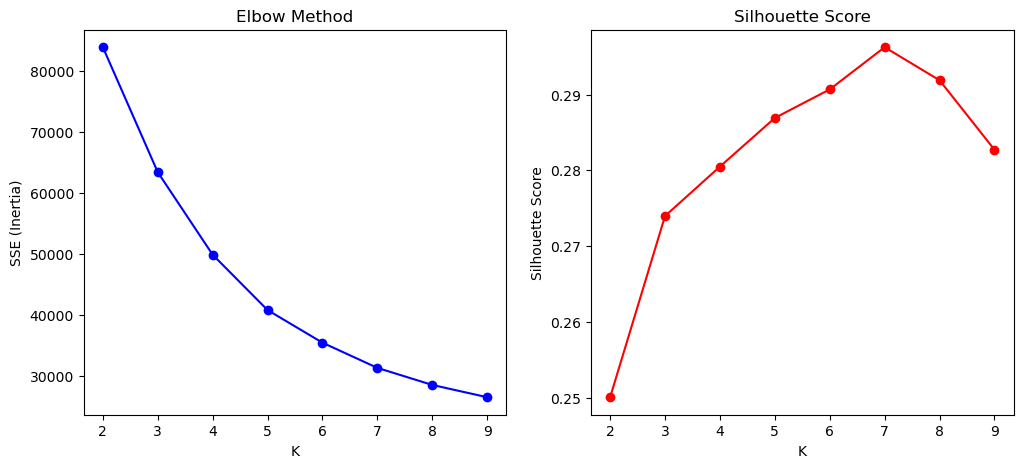

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["esg_score", "g_index", "net_profit"]])

inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

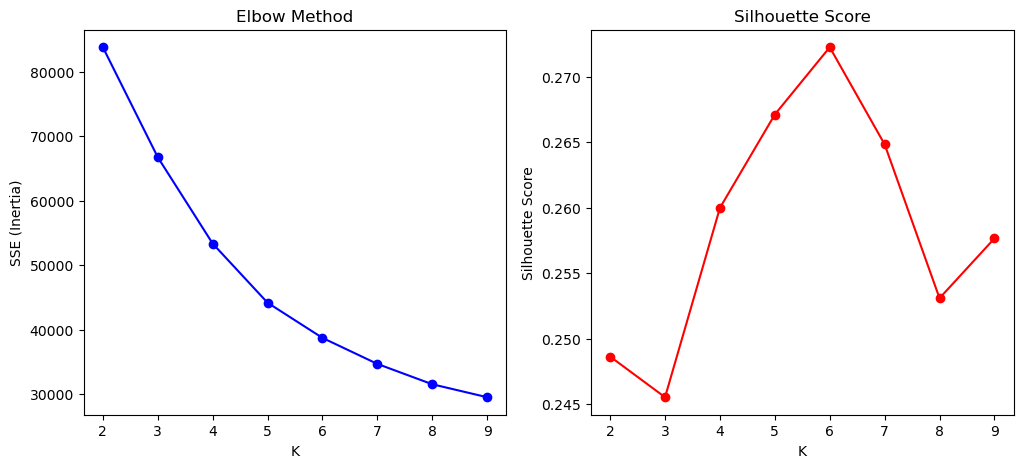

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[["esg_score", "g_index", "financial_health_index"]])

inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

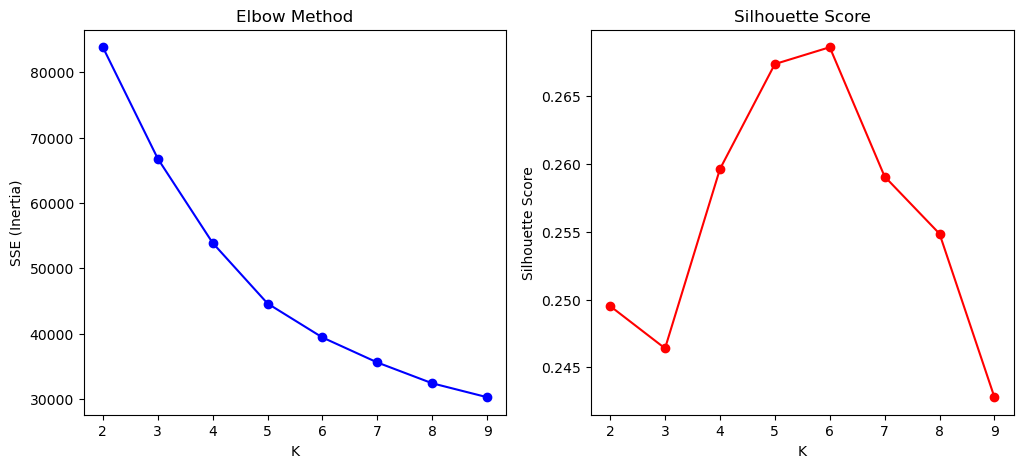

In [23]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel("K")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K, silhouette, 'ro-')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()